In [6]:
import os
import cv2
import numpy as np
import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog

In [7]:
DATA_DIR_TRAIN = 'data/train'
DATA_DIR_TEST = 'data/test'
DATA_DIR_VAL = 'data/val'

CLASSES = ['car', 'person', 'traffic sign', 'traffic light']
# NEG_CLASS = 'background'
MODEL_DIR = 'models/'
os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
# HOG Parameters (Must match what you use for inference later!)
# based on the standard configuration established by the original Dalal & Triggs paper (2005) for human detection.
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8), # divides image into a grid of squares, calculate the gradient for every pixel and pools them into a single histogram
    'cells_per_block': (2, 2), # performs normalization to handle lighting changes
    'block_norm': 'L2-Hys', # normalizes the histogram
    'visualize': False,
    'transform_sqrt': True # applies the square root to each pixel intensity before processing
}

PATCH_SIZE = (32, 64)

In [10]:
def load_and_extract_features(data_dir):
    X = []
    y = []
    
    print(f"Computing HOG features from {data_dir}...")
    
    for label_id, class_name in enumerate(CLASSES):
        path = os.path.join(data_dir, class_name)
        if not os.path.exists(path): continue
        
        print(f"Processing class: {class_name}")
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)
            img = cv2.imread(img_path)
            if img is None: continue
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            gray = cv2.resize(gray, PATCH_SIZE) 
            
            features = hog(gray, **HOG_PARAMS)
            X.append(features)
            y.append(class_name)

    return np.array(X), np.array(y)

In [11]:
X_train, y_train = load_and_extract_features(DATA_DIR_TRAIN)
X_val, y_val = load_and_extract_features(DATA_DIR_VAL)

X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))

print(f"Feature Matrix Shape: {X.shape}")

Computing HOG features from data/train...
Processing class: car
Processing class: person
Processing class: traffic sign
Processing class: traffic light
Computing HOG features from data/val...
Processing class: car
Processing class: person
Processing class: traffic sign
Processing class: traffic light
Feature Matrix Shape: (156905, 756)


In [12]:
np.savez_compressed('hog_features_multiclass.npz', X=X, y=y)

# data = np.load('hog_features_multiclass.npz')
# X = data['X']
# y = data['y']

In [13]:
# Train a separate SVM for each class (One-vs-Rest) or a single Multi-class SVM
# For object detection, we typically train "Car vs Background", "Person vs Background", etc.
# But scikit-learn LinearSVC handles multi-class automatically (one-vs-rest).

print("Training SVM...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
print(classification_report(y_test, preds))

# Save the model and the HOG parameters
model_name = 'hog_svm.pkl'
joblib.dump(model, os.path.join(MODEL_DIR, model_name))
print(f"Model saved to {MODEL_DIR}{model_name}")
MODEL_PATH = os.path.join(MODEL_DIR, model_name)

Training SVM...
               precision    recall  f1-score   support

          car       0.86      0.81      0.83     18119
       person       0.49      0.62      0.55      2422
traffic light       0.62      0.65      0.64      4769
 traffic sign       0.64      0.63      0.63      6071

     accuracy                           0.74     31381
    macro avg       0.65      0.68      0.66     31381
 weighted avg       0.75      0.74      0.74     31381

Model saved to models/hog_svm.pkl


# Evaluation

In [14]:
import pandas as pd
import cv2
import joblib
import numpy as np
import time
import os
from skimage.feature import hog
from collections import defaultdict

In [15]:
TEST_CSV = '../data/labels/test_labels.csv'
IMG_DIR = "../data/bdd100k_images_100k/100k/train"
NUM_TEST_IMAGES = 10  # Limit to 10 images for debugging (Increase to 100 or 1000 later)
IOU_THRESHOLDS = np.arange(0.5, 0.96, 0.05) # 0.5, 0.55, ..., 0.95
# IOU_THRESHOLDS = [0.1, 0.3, 0.5]

# HOG Parameters (MUST MATCH TRAINING)
WIN_SIZE = PATCH_SIZE
STEP_SIZE = 16
SCALE_FACTOR = 1.25

In [18]:
def get_iou(boxA, boxB):
    '''
    Measure how much two boxes overlap.
    '''    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA) # if boxes do not overlap, xB - xA or yB - yA will be negative -> 0 area
    # individual box areas
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Inclusion-Exclusion Principle
    unionArea = float(boxAArea + boxBArea - interArea)
    if unionArea == 0: return 0 # avoid division by zero
    return interArea / unionArea

def non_max_suppression(boxes, probs, overlapThresh=0.3):
    ''' 
    Filter overlapping bounding boxes.
    The sliding window will detect the same car several times (slightly shifted each time).
    We need to keep only the best one.
    '''
    if len(boxes) == 0: return [], [], []

    boxes = boxes.astype("float")
    pick = []
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
        
    return boxes[pick].astype("int"), probs[pick], pick

def detect_objects(model, img):
    detections = []
    confidences = []
    labels = []
    
    # Resize for speed (Critical for Python HOG)
    # ratio_x = img.shape[1] / 500
    # ratio_y = img.shape[0] / (500 * (img.shape[0]/img.shape[1]))
    # resized_img = cv2.resize(img, (500, int(500 * (img.shape[0]/img.shape[1]))))
    
    current_scale = 0
    scale_img = img.copy()
    
    while scale_img.shape[0] >= WIN_SIZE[1] and scale_img.shape[1] >= WIN_SIZE[0]:
        for y in range(0, scale_img.shape[0] - WIN_SIZE[1], STEP_SIZE):
            for x in range(0, scale_img.shape[1] - WIN_SIZE[0], STEP_SIZE):
                window = scale_img[y:y+WIN_SIZE[1], x:x+WIN_SIZE[0]]
                gray = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
                feats = hog(gray, **HOG_PARAMS).reshape(1, -1)
                
                # Get scores for ALL classes
                all_scores = model.decision_function(feats)[0] 
                
                # Find the class with the highest score
                best_class_index = np.argmax(all_scores)
                max_score = all_scores[best_class_index]
                pred_label = model.classes_[best_class_index]
                
                # Check threshold AND ensure it's not background
                if max_score > 0.2 and pred_label != 'background': 
                    
                    # Map back to Original Image Coordinates
                    # scale_multiplier = (SCALE_FACTOR ** current_scale)
                    # final_x = int(x * scale_multiplier * ratio_x)
                    # final_y = int(y * scale_multiplier * ratio_y)
                    # final_w = int(WIN_SIZE[0] * scale_multiplier * ratio_x)
                    # final_h = int(WIN_SIZE[1] * scale_multiplier * ratio_y)

                    scale_multiplier = (SCALE_FACTOR ** current_scale)
                    final_x = int(x * scale_multiplier * x)
                    final_y = int(y * scale_multiplier * y)
                    final_w = int(WIN_SIZE[0] * scale_multiplier * x)
                    final_h = int(WIN_SIZE[1] * scale_multiplier * y)

                    # We store [x1, y1, x2, y2, class_name] to help debugging
                    detections.append([final_x, final_y, final_x+final_w, final_y+final_h])
                    confidences.append(max_score)
                    labels.append(pred_label)
        
        new_w = int(scale_img.shape[1] / SCALE_FACTOR)
        new_h = int(scale_img.shape[0] / SCALE_FACTOR)
        scale_img = cv2.resize(scale_img, (new_w, new_h))
        current_scale += 1

    if len(detections) > 0:
        lbls = np.array(labels)
        final_boxes, final_probs, pick = non_max_suppression(np.array(detections), np.array(confidences))
        final_labels = lbls[pick]
        return final_boxes, final_probs, final_labels
    return [], [], []

def calculate_ap(rec, prec):
    # Compute Average Precision (Area under PR Curve)
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
def main():
    print("Loading Model & Data...")
    model = joblib.load(MODEL_PATH)
    df = pd.read_csv(TEST_CSV)
    
    unique_images = df['image'].unique()[:NUM_TEST_IMAGES] 
    all_preds = []   
    all_gts = []     
    latencies = []

    print(f"Starting inference on {len(unique_images)} images...")
    for i, img_name in enumerate(unique_images):
        full_img_name = img_name if img_name.endswith('.jpg') else img_name + '.jpg'
        img_path = os.path.join(IMG_DIR, full_img_name)
        
        img = cv2.imread(img_path)
        if img is None: continue

        # Measure Latency
        start = time.time()
        # Returns 3 lists: Boxes, Scores, Class Labels
        boxes, scores, labels = detect_objects(model, img) 
        end = time.time()
        latencies.append(end - start)

        # Store Predictions
        for box, score, label in zip(boxes, scores, labels):
            all_preds.append({
                'image': img_name,
                'class': label,
                'score': score,
                'bbox': box
            })
            
        # Store Ground Truths
        gts = df[df['image'] == img_name]
        for _, row in gts.iterrows():
            # Check if this GT is one of our 4 target classes
            if row['category'] in ['car', 'person', 'traffic sign', 'traffic light']:
                all_gts.append({
                    'image': img_name,
                    'class': row['category'],
                    'bbox': [row['x1'], row['y1'], row['x2'], row['y2']]
                })
        
        print(f"Processed {i+1}/{len(unique_images)} - {img_name} - found {len(boxes)} objects")

    avg_latency = np.mean(latencies)
    print(f"\nAverage Latency: {avg_latency:.4f} seconds/image")

    # CALCULATE mAP
    print("\nCalculating metrics...")
    target_classes = ['car', 'person', 'traffic sign', 'traffic light']
    mean_aps = []

    for cls in target_classes:
        print(f"--- Evaluating Class: {cls} ---")
        aps_per_threshold = []
        
        # Filter logic: specific to THIS class
        class_preds = [p for p in all_preds if p['class'] == cls]
        class_gts = [g for g in all_gts if g['class'] == cls]
        
        if len(class_gts) == 0:
            print("  No Ground Truths for this class in this subset.")
            continue

        # Sort Predictions by Confidence Score (High to Low)
        class_preds = sorted(class_preds, key=lambda x: x['score'], reverse=True)
        
        for iou_thresh in IOU_THRESHOLDS:
            tp = np.zeros(len(class_preds))
            fp = np.zeros(len(class_preds))
            
            # Keep track of which GT box has already been matched to avoid double counting
            # key: image_name, value: list of matched GT indices
            matched_gt_indices = defaultdict(set)
            
            for p_idx, pred in enumerate(class_preds):
                img_id = pred['image']
                bb_pred = pred['bbox']
                
                # Get GTs for this specific image
                # We store original index 'g_idx' to track uniqueness
                img_gts_with_idx = [(i, g) for i, g in enumerate(class_gts) if g['image'] == img_id]
                
                best_iou = 0
                best_gt_idx = -1
                
                # Find the single best GT match for this prediction
                for (g_idx, gt) in img_gts_with_idx:
                    # Logic: If this GT is already matched, we cannot use it again for this threshold
                    if g_idx in matched_gt_indices[img_id]:
                        continue 
                        
                    iou = get_iou(bb_pred, gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = g_idx
                
                # Threshold Check
                if best_iou >= iou_thresh:
                    tp[p_idx] = 1
                    matched_gt_indices[img_id].add(best_gt_idx) # Lock this GT
                else:
                    fp[p_idx] = 1
            
            # Compute AP
            fp_cumsum = np.cumsum(fp)
            tp_cumsum = np.cumsum(tp)
            rec = tp_cumsum / len(class_gts)
            prec = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
            
            ap = calculate_ap(rec, prec)
            aps_per_threshold.append(ap)
        
        class_map = np.mean(aps_per_threshold)
        mean_aps.append(class_map)
        print(f"  mAP@0.5:0.95: {class_map:.4f}")

    print(f"\n=== FINAL RESULTS ===")
    print(f"Total mAP: {np.mean(mean_aps):.4f}")
    print(f"Latency: {avg_latency:.4f}s")
    
if __name__ == "__main__":
    main()

Debug: Visualizing 00f7eac8-5193d600
Found 1276 boxes.
Top 5 Scores: [1.99245066 1.84613779 1.70082635 1.67999233 1.63300322]


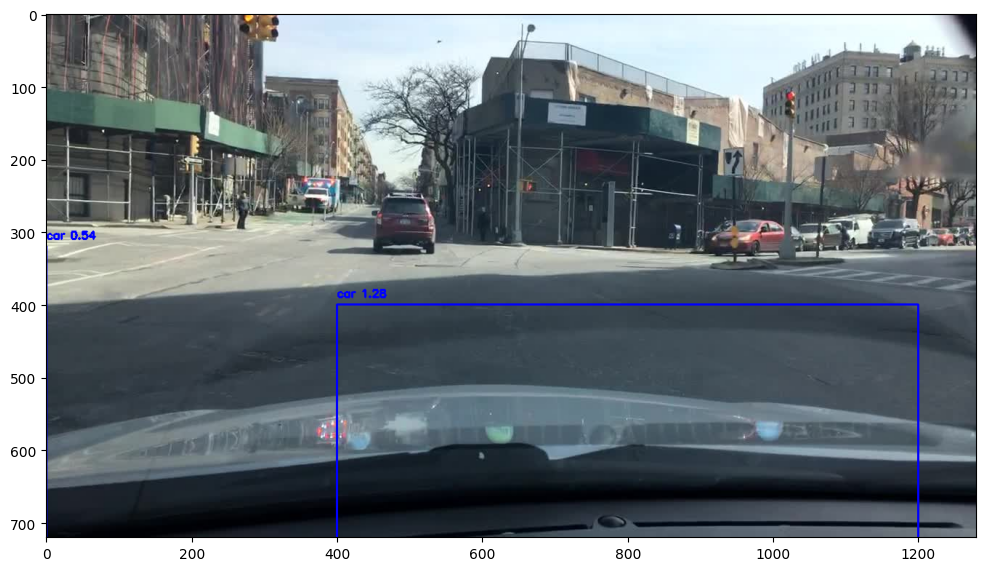

In [19]:
# Quick Debug Visualization
import cv2
import matplotlib.pyplot as plt

model = joblib.load(MODEL_PATH)

# Load one test image
# img_name = unique_images[0] # Get first image from your list
img_name = "00f7eac8-5193d600"
img_path = os.path.join(IMG_DIR, img_name if img_name.endswith('.jpg') else img_name+'.jpg')
img = cv2.imread(img_path)

# Run detection with a LOWER threshold
# We manually override the threshold inside detect_objects or just print raw scores
print(f"Debug: Visualizing {img_name}")
boxes, scores, labels = detect_objects(model, img)

print(f"Found {len(boxes)} boxes.")
print(f"Top 5 Scores: {scores[:5]}") 

for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    # Draw Blue Box
    # print(f"{label}, {x1}, {y1}, {x2}, {y2}")
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(img, f"{label} {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()